In [1]:
import numpy as np
import matplotlib.pyplot as plt

from reservoirpy.nodes import Reservoir, Ridge
from reservoirpy.datasets import mackey_glass

import reservoirpy as rpy
rpy.verbosity(0)

0

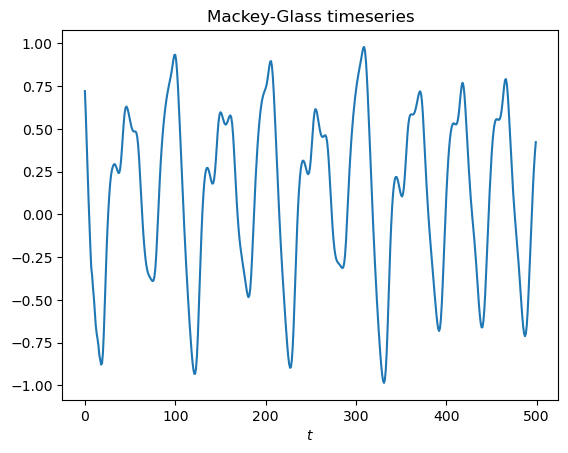

In [2]:
X = mackey_glass(2000)

# rescale between -1 and 1
X = 2 * (X - X.min()) / (X.max() - X.min()) - 1

plt.figure()
plt.xlabel("$t$")
plt.title("Mackey-Glass timeseries")
plt.plot(X[:500])
plt.show()

In [3]:
UNITS = 100               # - number of neurons
LEAK_RATE = 0.3           # - leaking rate
SPECTRAL_RADIUS = 1.25    # - spectral radius of W
INPUT_SCALING = 1.0       # - input scaling
RC_CONNECTIVITY = 0.1     # - density of reservoir internal matrix
INPUT_CONNECTIVITY = 0.2  # and of reservoir input matrix
REGULARIZATION = 1e-8     # - regularization coefficient for ridge regression
SEED = 1234               # for reproductibility

In [4]:
states = []
spectral_radii = [0.1, 1.25, 10.0]
for spectral_radius in spectral_radii:
    reservoir = Reservoir(
        units=UNITS,
        sr=spectral_radius,
        input_scaling=INPUT_SCALING,
        lr=LEAK_RATE,
        rc_connectivity=RC_CONNECTIVITY,
        input_connectivity=INPUT_CONNECTIVITY,
        seed=SEED,
    )

    s = reservoir.run(X[:500])
    states.append(s)



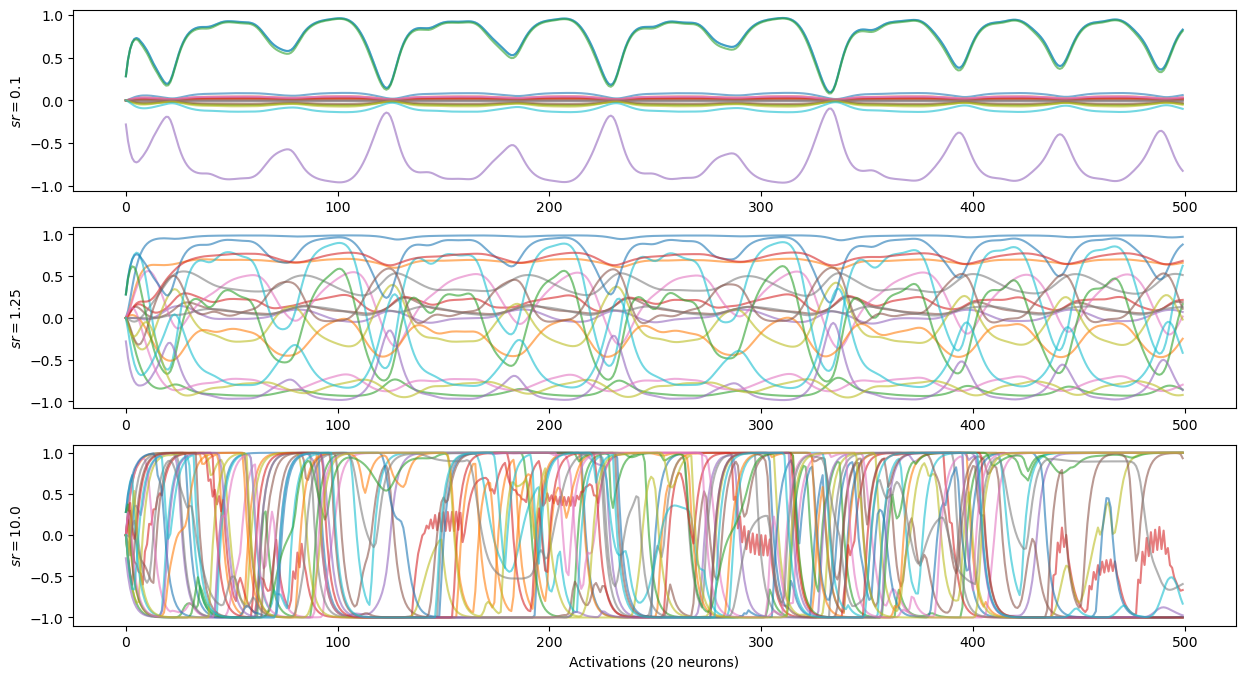

In [5]:
UNITS_SHOWN = 20

plt.figure(figsize=(15, 8))
for i, s in enumerate(states):
    plt.subplot(len(spectral_radii), 1, i+1)
    plt.plot(s[:, :UNITS_SHOWN], alpha=0.6)
    plt.ylabel(f"$sr={spectral_radii[i]}$")
plt.xlabel(f"Activations ({UNITS_SHOWN} neurons)")
plt.show()

In [6]:
states = []
input_scalings = [0.1, 1.0, 10.]
for input_scaling in input_scalings:
    reservoir = Reservoir(
        units=UNITS,
        sr=SPECTRAL_RADIUS,
        input_scaling=input_scaling,
        lr=LEAK_RATE,
        rc_connectivity=RC_CONNECTIVITY,
        input_connectivity=INPUT_CONNECTIVITY,
        seed=SEED,
    )

    s = reservoir.run(X[:500])
    states.append(s)

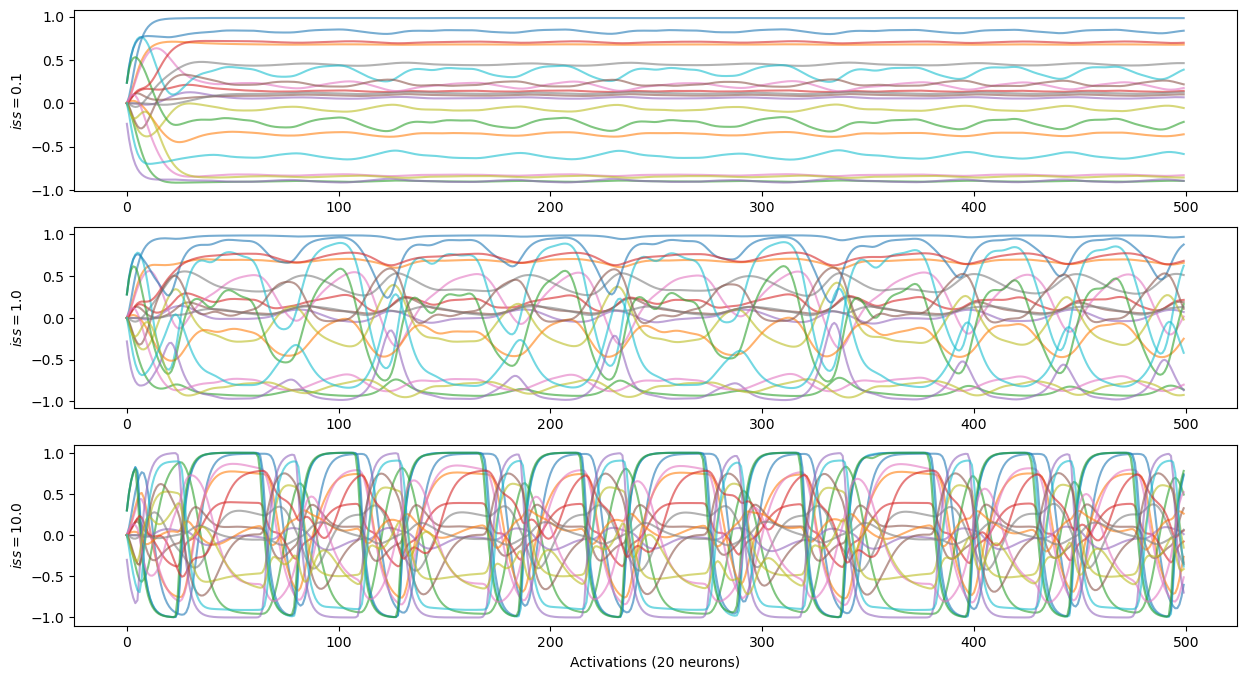

In [7]:
UNITS_SHOWN = 20

plt.figure(figsize=(15, 8))
for i, s in enumerate(states):
    plt.subplot(len(input_scalings), 1, i+1)
    plt.plot(s[:, :UNITS_SHOWN], alpha=0.6)
    plt.ylabel(f"$iss={input_scalings[i]}$")
plt.xlabel(f"Activations ({UNITS_SHOWN} neurons)")
plt.show()

In [8]:
def correlation(states, inputs):
    correlations = [np.corrcoef(states[:, i].flatten(), inputs.flatten())[0, 1] for i in range(states.shape[1])]
    return np.mean(np.abs(correlations))


In [9]:
print("input_scaling    correlation")
for i, s in enumerate(states):
    corr = correlation(states[i], X[:500])
    print(f"{input_scalings[i]: <13}    {corr}")

input_scaling    correlation
0.1              0.16324249555087267
1.0              0.45607456956635983
10.0             0.5844237964783201


In [10]:
import json

hyperopt_config = {
    "exp": "hyperopt-multiscroll",    # the experimentation name
    "hp_max_evals": 200,              # the number of differents sets of parameters hyperopt has to try
    "hp_method": "random",            # the method used by hyperopt to chose those sets (see below)
    "seed": 42,                       # the random state seed, to ensure reproducibility
    "instances_per_trial": 5,         # how many random ESN will be tried with each sets of parameters
    "hp_space": {                     # what are the ranges of parameters explored
        "N": ["choice", 500],             # the number of neurons is fixed to 500
        "sr": ["loguniform", 1e-2, 10],   # the spectral radius is log-uniformly distributed between 1e-2 and 10
        "lr": ["loguniform", 1e-3, 1],    # idem with the leaking rate, from 1e-3 to 1
        "input_scaling": ["choice", 1.0], # the input scaling is fixed
        "ridge": ["loguniform", 1e-8, 1e1],        # and so is the regularization parameter.
        "seed": ["choice", 1234]          # an other random seed for the ESN initialization
    }
}

# we precautionously save the configuration in a JSON file
# each file will begin with a number corresponding to the current experimentation run number.
with open(f"{hyperopt_config['exp']}.config.json", "w+") as f:
    json.dump(hyperopt_config, f)

In [25]:
from reservoirpy.datasets import doublescroll

timesteps = 2000
x0 = [0.37926545, 0.058339, -0.08167691]
X = doublescroll(timesteps, x0=x0, method="RK23")
np.shape(X)

(2000, 3)

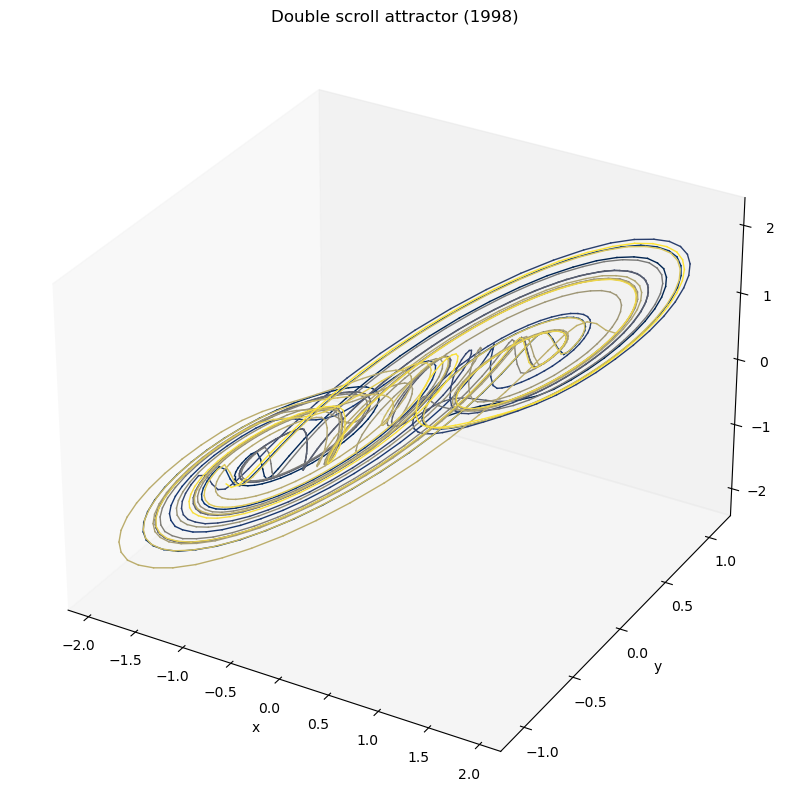

In [12]:
fig = plt.figure(figsize=(10, 10))
ax  = fig.add_subplot(111, projection='3d')
ax.set_title("Double scroll attractor (1998)")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
ax.grid(False)

for i in range(timesteps-1):
    ax.plot(X[i:i+2, 0], X[i:i+2, 1], X[i:i+2, 2], color=plt.cm.cividis(255*i//timesteps), lw=1.0)

plt.show()

In [15]:
from reservoirpy.observables import nrmse, rsquare
#Objective functions accepted by ReservoirPy must respect some conventions:
#  - dataset and config arguments are mandatory, like the empty '*' expression.
#  - all parameters that will be used during the search must be placed after the *.
#  - the function must return a dict with at least a 'loss' key containing the result
# of the loss function. You can add any additional metrics or information with other
# keys in the dict. See hyperopt documentation for more informations.
def objective(dataset, config, *, input_scaling, N, sr, lr, ridge, seed):
    # This step may vary depending on what you put inside 'dataset'
    x_train, x_test, y_train, y_test = dataset

    # You can access anything you put in the config
    # file from the 'config' parameter.
    instances = config["instances_per_trial"]

    # The seed should be changed across the instances,
    # to be sure there is no bias in the results
    # due to initialization.
    variable_seed = seed

    losses = []; r2s = [];
    for n in range(instances):
        # Build your model given the input parameters
        reservoir = Reservoir(
            units=N,
            sr=sr,
            lr=lr,
            input_scaling=input_scaling,
            seed=variable_seed
        )

        readout = Ridge(ridge=ridge)

        model = reservoir >> readout


        # Train your model and test your model.
        predictions = model.fit(x_train, y_train) \
                           .run(x_test)

        loss = nrmse(y_test, predictions, norm_value=np.ptp(x_train))
        r2 = rsquare(y_test, predictions)

        # Change the seed between instances
        variable_seed += 1

        losses.append(loss)
        r2s.append(r2)

    # Return a dictionnary of metrics. The 'loss' key is mandatory when
    # using hyperopt.
    return {'loss': np.mean(losses),
            'r2': np.mean(r2s)}

In [16]:
train_len = 1000
forecast = 2

X_train = X[:train_len]
Y_train = X[forecast : train_len + forecast]

X_test = X[train_len : -forecast]
Y_test = X[train_len + forecast:]

dataset = (X_train, X_test, Y_train, Y_test)

In [17]:
from reservoirpy.datasets import to_forecasting

X_train, X_test, Y_train, Y_test = to_forecasting(X, forecast=forecast, test_size=train_len-forecast)

In [22]:
from reservoirpy.hyper import research
best = research(objective, dataset, f"{hyperopt_config['exp']}.config.json", ".")

100%|██████████| 200/200 [12:23<00:00,  3.72s/trial, best loss: 0.0005308193131664731]


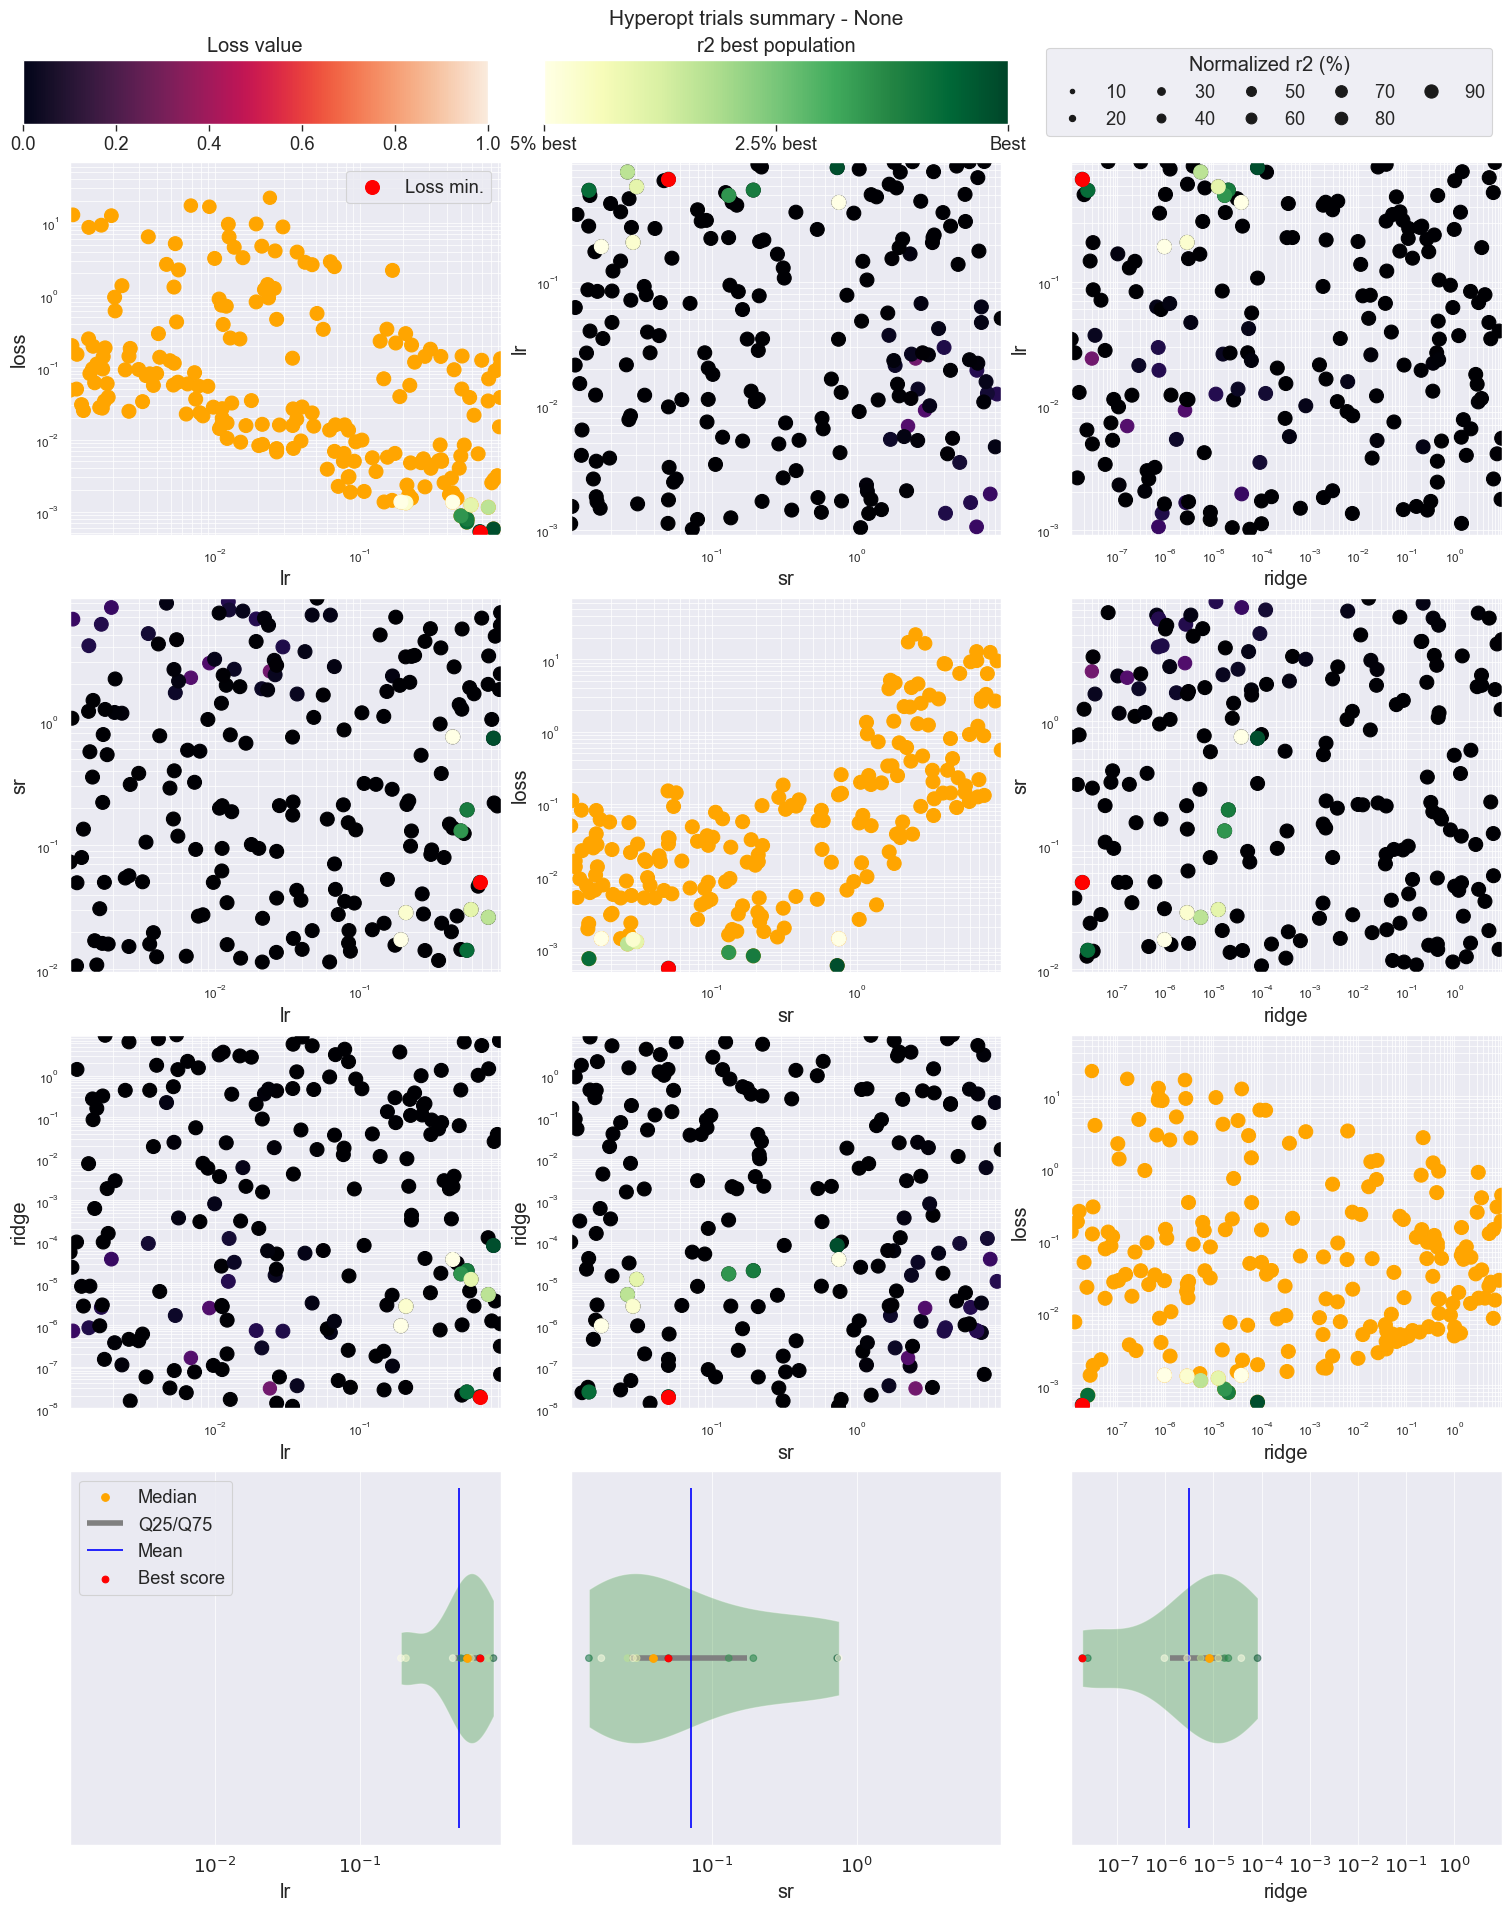

In [23]:
from reservoirpy.hyper import plot_hyperopt_report
fig = plot_hyperopt_report(hyperopt_config["exp"], ("lr", "sr", "ridge"), metric="r2")